# Approach

1. Compute pareto on code occurences - do manually for now - DONE
2. Generate lookup list based on top 80% - do manually for now - DONE
3. Replace codes with lookups in original categorical columns in claims file - DONE
4. Use pd.get_dummies to generate ohe columns - DONE (if then else loops)
5. Generate month, week, dayof month, day of week for - DONE
    - Claim start date
    - Claim end date
6. Compute derived variables - DONE
   - age bands - DONE
   - claim duration - already available
   - Lag Days - cannot 
5. Concatenate Beneficiary info - DONE
6. Consider mapping DX codes to HCC conditions to reduce sparseness
7. Drop columns - DONE IN EXCLUDE COLUMNS
    - SP_ columns
    - yearly sums
8. Figure out the proc string issue - 
9. Identify KPI transformations and replace nulls with medians - DONE
   - compute logs of KPIs

Outstanding
1. ...only read code values as str in read_csv of input datafile!!!!!

Later...
1. switch to outpatient
2. Replace DRG CD with ohe
3. Purchase actual CMS files for recent years if possible...say 10K records

# Columns info
- **CLM_ID: Claim ID**
- **DESYNPUF_ID:** Beneficiary Code
It's the identifier of the patient. Could be multiple claims per patient. 
- **SEGMENT:** Claim Line Segment. Drop.
- **CLM_FROM_DT:** Claims start date
- **CLM_THRU_DT:** Claims end date
- **PRVDR_NUM:** Provider Institution. Company who made the claim (hospital).
- **CLM_PMT_AMT:** Claim Payment Amount.
- **NCH_PRMRY_PYR_CLM_PD_AMT:** NCH Primary Payer Claim Paid Amount. One of the KPI's.
- **AT_PHYSN_NPI:** Attending Physician (physician who made the claim).
- **OP_PHYSN_NPI:** Operating Physician – National Provider Identifier Number.
- **OT_PHYSN_NPI:** Other Physician – National Provider Identifier Number.
- **CLM_ADMSN_DT:** Inpatient admission date.
- **ADMTNG_ICD9_DGNS_CD:**  Claim Admitting Diagnosis Code. Drop (in clustering)
- **CLM_PASS_THRU_PER_DIEM_AMT:** Claim Pass Thru Per Diem Amount
The amount of the established reimbursable costs for the current year divided by the estimated Medicare
days for the current year (all PPS claims), as calculated by the FI and reimbursement staff. Items
reimbursed as a pass through include capital–related costs; direct medical education costs; kidney
acquisition costs for hospitals approved as RTCs; and bad debts (per Provider Reimbursement Manual,
Part 1, Section 2405.2). Note: Pass through are not included in the Claim Payment Amount. 
- **NCH_BENE_IP_DDCTBL_AMT:** NCH Beneficiary Inpatient Deductible Amount
The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the
institutional claim. 
- **NCH_BENE_PTA_COINSRNC_LBLTY_AM:** NCH Beneficiary Part A Coinsurance Liability Amount
The amount of money for which the intermediary has determined that the beneficiary is liable for Part A
coinsurance on the institutional claim. 
- **CLM_UTLZTN_DAY_CNT:** Claim Utilization Day Count. 
On an institutional claim, the number of covered days of care that are chargeable to Medicare facility
utilization that includes full days, coinsurance days, and lifetime reserve days. It excludes any days
classified as non–covered, leave of absence days, and the day of discharge or death.
- **NCH_BENE_DSCHRG_DT:** Inpatient discharged date. 
Effective with Version H, on an inpatient and HHA claim, the date the beneficiary was discharged from
the facility or died (used for internal CWFMQA editing purposes.) 
- **CLM_DRG_CD:** Claim Diagnosis Related Group Code.
- **ICD9_DGNS_CD_1:** Line Diagnosis Code 1. For every claim in order to justify the claim the physician has to say the patient has been dignosed with the following conditions. I did the following procedures (1-10).
- **ICD9_DGNS_CD_2:** ???
- **ICD9_DGNS_CD_3:** ???
- **ICD9_DGNS_CD_4:** ???
- **ICD9_DGNS_CD_5:** ???
- **ICD9_DGNS_CD_6:** ???
- **ICD9_DGNS_CD_7:** ???
- **ICD9_DGNS_CD_8:** Claim Diagnosis Code 8
- **ICD9_DGNS_CD_9:** Diagonisis
- **ICD9_DGNS_CD_10:** Claim Diagnosis Code 10. Representing different conditions. 
- **ICD9_PRCDR_CD_1:** Procedure.
- **ICD9_PRCDR_CD_2:** ???
- **ICD9_PRCDR_CD_3:** ???
- **ICD9_PRCDR_CD_5:** ???
- **ICD9_PRCDR_CD_6:** Claim Procedure Code 6

# Using the following columns (for clustering)
- NCH_BENE_DSCHRG_DT. Inpatient discharged date. Effective with Version H, on an inpatient and HHA claim, the date the beneficiary was discharged from the facility or died (used for internal CWFMQA editing purposes.)
- NCH_PRMRY_PYR_CLM_PD_AMT: NCH Primary Payer Claim Paid Amount. One of the KPI's.
- CLM_FROM_DT: Claims start date
- CLM_THRU_DT: Claims end date
- CLM_ADMSN_DT: Inpatient admission date.
- PRVDR_NUM: Provider Institution. Company who made the claim (hospital).
- AT_PHYSN_NPI: Attending Physician (physician who made the claim).
- OP_PHYSN_NPI: Operating Physician – National Provider Identifier Number.
- ICD9_DGNS_CD_1
- ICD9_DGNS_CD_2
- ICD9_DGNS_CD_3
- ICD9_DGNS_CD_4
- ICD9_DGNS_CD_5
- ICD9_DGNS_CD_6
- ICD9_DGNS_CD_7
- ICD9_DGNS_CD_8
- ICD9_DGNS_CD_9
- ICD9_DGNS_CD_10

In [1]:
!pip install missingno

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
# Imports
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#Plot styling/configurations 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 14,8
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 13})
import warnings
warnings.filterwarnings('ignore')
seq_col_brew = sns.color_palette("YlGnBu_r", 4)
sns.set_palette(seq_col_brew)
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
data = pd.read_csv('DE1_0_2008_to_2010_Inpatient_Claims_NoHCPCS_Sample_1.csv', dtype=str)

In [20]:
data.dtypes

DESYNPUF_ID                       object
CLM_ID                            object
SEGMENT                           object
CLM_FROM_DT                       object
CLM_THRU_DT                       object
PRVDR_NUM                         object
CLM_PMT_AMT                       object
NCH_PRMRY_PYR_CLM_PD_AMT          object
AT_PHYSN_NPI                      object
OP_PHYSN_NPI                      object
OT_PHYSN_NPI                      object
CLM_ADMSN_DT                      object
ADMTNG_ICD9_DGNS_CD               object
CLM_PASS_THRU_PER_DIEM_AMT        object
NCH_BENE_IP_DDCTBL_AMT            object
NCH_BENE_PTA_COINSRNC_LBLTY_AM    object
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    object
CLM_UTLZTN_DAY_CNT                object
NCH_BENE_DSCHRG_DT                object
CLM_DRG_CD                        object
ICD9_DGNS_CD_1                    object
ICD9_DGNS_CD_2                    object
ICD9_DGNS_CD_3                    object
ICD9_DGNS_CD_4                    object
ICD9_DGNS_CD_5  

In [4]:
data.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,ADMTNG_ICD9_DGNS_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6
0,00013D2EFD8E45D1,196661176988405,1,20100312,20100313,2600GD,4000,0,3139083564,NaN,NaN,20100312,4580,0,1100,0,0,1,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,196201177000368,1,20090412,20090418,3900MB,26000,0,6476809087,NaN,NaN,20090412,7866,0,1068,0,0,6,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,196661177015632,1,20090831,20090902,3900HM,5000,0,611998537,611998537,NaN,20090831,6186,0,1068,0,0,2,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,6186,V5866,NaN,NaN,NaN
3,00016F745862898F,196091176981058,1,20090917,20090920,3913XU,5000,0,4971602784,NaN,1119000316,20090917,29590,0,1068,0,0,3,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016F745862898F,196261176983265,1,20100626,20100701,3900MB,16000,0,6408400473,1960859579,NaN,20100626,5849,0,1100,0,0,5,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN


# Basic Analysis

In [6]:
data['NCH_PRMRY_PYR_CLM_PD_AMT'].value_counts()

0        43988
5000        79
6000        62
4000        62
8000        52
7000        50
11000       49
68000       45
10000       43
9000        42
3000        39
2000        34
15000       30
12000       24
14000       24
17000       21
13000       20
16000       19
20000       18
23000       17
18000       17
26000       15
1000        14
22000       14
25000       14
24000       13
36000       12
29000       12
19000       11
27000       10
35000        9
33000        9
31000        9
21000        9
28000        8
41000        8
39000        7
47000        6
40000        6
30000        5
32000        5
800          4
48000        4
38000        3
57000        3
55000        3
50000        3
58000        3
59000        3
52000        3
44000        2
56000        2
300          2
53000        2
500          2
46000        2
400          2
43000        2
63000        2
34000        2
42000        2
67000        2
60000        1
45000        1
65000        1
49000        1
51000     

In [7]:
data['PRVDR_NUM'].value_counts()

23006G    502
1000AH    418
3600NG    359
2600ZT    297
3400XN    292
1401RR    290
2100WC    259
0501MA    251
1100TC    231
4500DP    227
0400AC    225
1002DC    211
0503SD    207
4400MM    205
3100JN    203
3301QB    195
2201YM    192
1700JJ    185
3100VC    181
4500NJ    176
1001ZQ    175
1100SK    174
1500QB    171
3401MN    168
0505KQ    164
3400SP    157
1400RU    156
1000AV    155
4401DM    155
05018N    152
4900NA    151
15008B    150
0700JR    149
2000HG    147
3302VG    144
3100VM    141
1002ZT    141
2100NQ    140
0300DD    138
3302BQ    138
1800WP    137
3902XB    136
3400ZQ    135
1001NA    134
2501QH    131
36008A    129
1501ZA    129
1900PA    128
0300CC    128
2200GD    123
10026U    123
2600QH    122
0502VR    122
0700QA    119
1600GH    119
14018H    119
4900GV    118
3600CS    117
0507AB    115
2200MM    114
2300KS    112
2100ZH    111
3301BB    109
3900NM    109
1402CR    107
4506UA    107
0600GH    106
5201TA    106
0500VS    106
3300JQ    105
1002YC    105
3800ZR

In [8]:
data['AT_PHYSN_NPI'].value_counts()

9011551271    355
2482526289    286
3709260297    253
8198589276    251
1499149511    246
339606302     206
4199341016    190
4712447093    181
9762148833    179
3653175371    176
8237370698    161
8155444621    160
9647966678    155
9656623009    154
9692316785    150
280196853     149
5195331021    146
7872369581    144
2241050583    139
7573799103    129
7234907498    129
1521516773    127
6928498058    121
6052903246    120
4315939137    117
4123724626    117
3198317523    117
5333645593    116
2329429575    113
2288682504    109
5283486435    107
1323185717    104
3072492449    103
3413094726     96
2805423952     95
4431795018     95
1722732755     93
2675886155     92
8303540566     91
9535845163     90
2584638480     88
9156656040     86
2357170336     84
5468245430     83
1125094439     82
3867083193     82
3577967660     80
1477804124     78
5347396351     78
1117398893     77
448346478      77
6774943343     76
4842645658     75
1848534533     75
8642239537     71
7087360414

In [9]:
data['OP_PHYSN_NPI'].value_counts()

9612910514    222
2482526289    165
3663285618    146
3236463392    137
2017370966    132
3394235812    117
6842958143    108
4199341016    108
8184097058    104
3653175371    102
280196853     100
8155444621     94
8431954322     94
9656623009     92
9245454272     89
5118340367     86
8237370698     85
7573799103     83
5401024033     81
1117398893     81
9692316785     80
9647966678     80
3563005767     76
5333645593     76
2241050583     75
2329429575     74
7805580849     71
9156656040     70
4123724626     69
6052903246     68
1588513707     67
8262337305     65
5283486435     65
2374867733     65
1528376444     63
7939755761     60
9558964003     58
2778953082     57
800087611      56
4306262924     56
3577967660     56
3413094726     55
3072492449     55
9984383363     53
2675886155     51
7402142447     51
2805423952     50
1125094439     49
9535845163     49
1649970161     45
1722732755     45
3692509901     45
7486635514     43
6691953342     42
2389594485     42
929561351 

In [10]:
data['ICD9_DGNS_CD_1'].value_counts()

486      1614
V5789    1225
41401    1151
389      1132
49121    1050
4280      973
5990      917
42731     844
41071     811
71536     754
43491     732
5849      713
51881     551
78659     521
5070      476
7802      472
27651     438
6826      370
42823     340
82021     335
4359      330
5789      294
43310     294
71535     290
41519     265
49122     260
5770      255
78650     249
71596     247
56211     240
49322     233
42781     230
42833     228
5609      226
51884     222
42789     218
8208      216
29570     210
845       197
3310      192
25080     190
82009     186
2761      185
5589      184
99859     184
72402     178
4580      160
3842      158
56081     158
56212     152
45341     151
73313     142
57400     133
4241      128
4414      125
5601      123
41400     123
72210     121
43411     119
42821     119
42831     118
431       114
40391     114
78097     112
4271      112
5119      111
4660      109
42843     109
2859      108
185       107
2767      106
99662 

In [11]:
data['ICD9_DGNS_CD_10'].value_counts()

4019     113
25000     81
5990      75
4280      69
2724      65
41401     64
5849      54
2449      52
53081     49
42731     48
496       48
2761      47
40390     42
2859      35
2720      33
5856      33
41400     31
73300     31
27651     30
2851      29
2948      27
311       27
5859      26
4254      25
40391     24
2768      24
E8889     23
412       23
3051      22
2639      21
486       20
5180      19
E8859     18
V4581     18
V1582     18
3310      17
71590     16
2875      15
2762      15
27801     15
56400     15
4589      15
42789     15
V5861     14
5070      14
60000     14
V4501     14
4168      14
V4582     13
V1254     13
28521     12
5119      12
6826      12
5853      12
V103      12
27800     12
V5866     12
V5867     12
43820     11
2767      11
99592     11
28529     11
30000     11
25060     11
7802      10
2930      10
33829     10
4240      10
78720     10
49121     10
4439      10
3004      10
99591     10
7245       9
3320       9
3659       9
34590      9

In [12]:
data['ICD9_PRCDR_CD_5'].value_counts()

4019     205
2724     128
41401    108
25000    100
4280      96
42731     81
53081     78
5990      52
40390     52
4111      50
51881     50
2449      50
2859      47
2720      47
5849      45
3051      44
2851      43
V1582     35
V4582     34
5856      33
486       32
71590     31
5859      30
40391     28
2768      28
5180      27
V1254     26
2762      26
V4581     26
27800     25
9971      24
99592     23
V5866     23
4439      23
4148      22
2639      22
V5861     22
99591     22
41071     21
5601      21
5185      21
78552     21
41400     20
49121     20
4139      20
5070      19
311       19
73300     18
2948      18
2760      17
42789     16
60000     16
3970      16
41402     16
43310     15
V1046     15
27801     14
2875      14
27651     14
9974      14
496       13
78959     12
389       12
34831     12
V5867     12
29410     12
4589      12
99812     12
28521     12
591       11
2767      11
V1005     11
6826      11
5853      11
4168      11
70703     11
3004      11

In [13]:
data['ICD9_PRCDR_CD_5'].unique()

array([nan, '53081', '43491', '41402', '42830', '78550', '4280', '1985',
       '51881', '42611', '2948', '4169', '3694', '7802', '25000', 'V4283',
       '73319', '34590', '48283', '4111', '4131', '2768', '41071',
       '78552', '72886', 'E8889', '43820', '42789', '2113', '78551',
       '2875', '70724', '79029', '1977', '4184', '486', '60000', '53171',
       '5128', '4148', '2764', 'V1581', '5859', '389', '3051', '73300',
       'V5866', '4589', '73025', '5119', 'V4581', '2749', '570', 'V4589',
       '45981', '5990', '41401', '42731', '2989', '34931', '44422',
       '42821', '30000', '2859', '4019', '9971', 'V421', '27800', '78003',
       'E8881', '41400', '45342', '4168', '496', '3970', '29689', '40391',
       '9986', '2720', '5070', '845', '78959', '25200', '30503', '42833',
       '1983', '28731', '5185', '1970', '3591', '29620', '71690', '71590',
       '2851', '4439', '99739', '28860', '34830', '4264', '4242', '5997',
       '3569', '7994', '7919', '5180', '9974', '2449', 

In [15]:
len(data['DESYNPUF_ID'].unique())

25481

In [16]:
data.isnull().sum()

DESYNPUF_ID                           0
CLM_ID                                0
SEGMENT                               0
CLM_FROM_DT                          47
CLM_THRU_DT                          47
PRVDR_NUM                             0
CLM_PMT_AMT                           0
NCH_PRMRY_PYR_CLM_PD_AMT              0
AT_PHYSN_NPI                        441
OP_PHYSN_NPI                      18696
OT_PHYSN_NPI                      39833
CLM_ADMSN_DT                          0
ADMTNG_ICD9_DGNS_CD                 395
CLM_PASS_THRU_PER_DIEM_AMT            0
NCH_BENE_IP_DDCTBL_AMT             1439
NCH_BENE_PTA_COINSRNC_LBLTY_AM        0
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM        0
CLM_UTLZTN_DAY_CNT                   47
NCH_BENE_DSCHRG_DT                    0
CLM_DRG_CD                            0
ICD9_DGNS_CD_1                       64
ICD9_DGNS_CD_2                      335
ICD9_DGNS_CD_3                      826
ICD9_DGNS_CD_4                     1837
ICD9_DGNS_CD_5                     3479


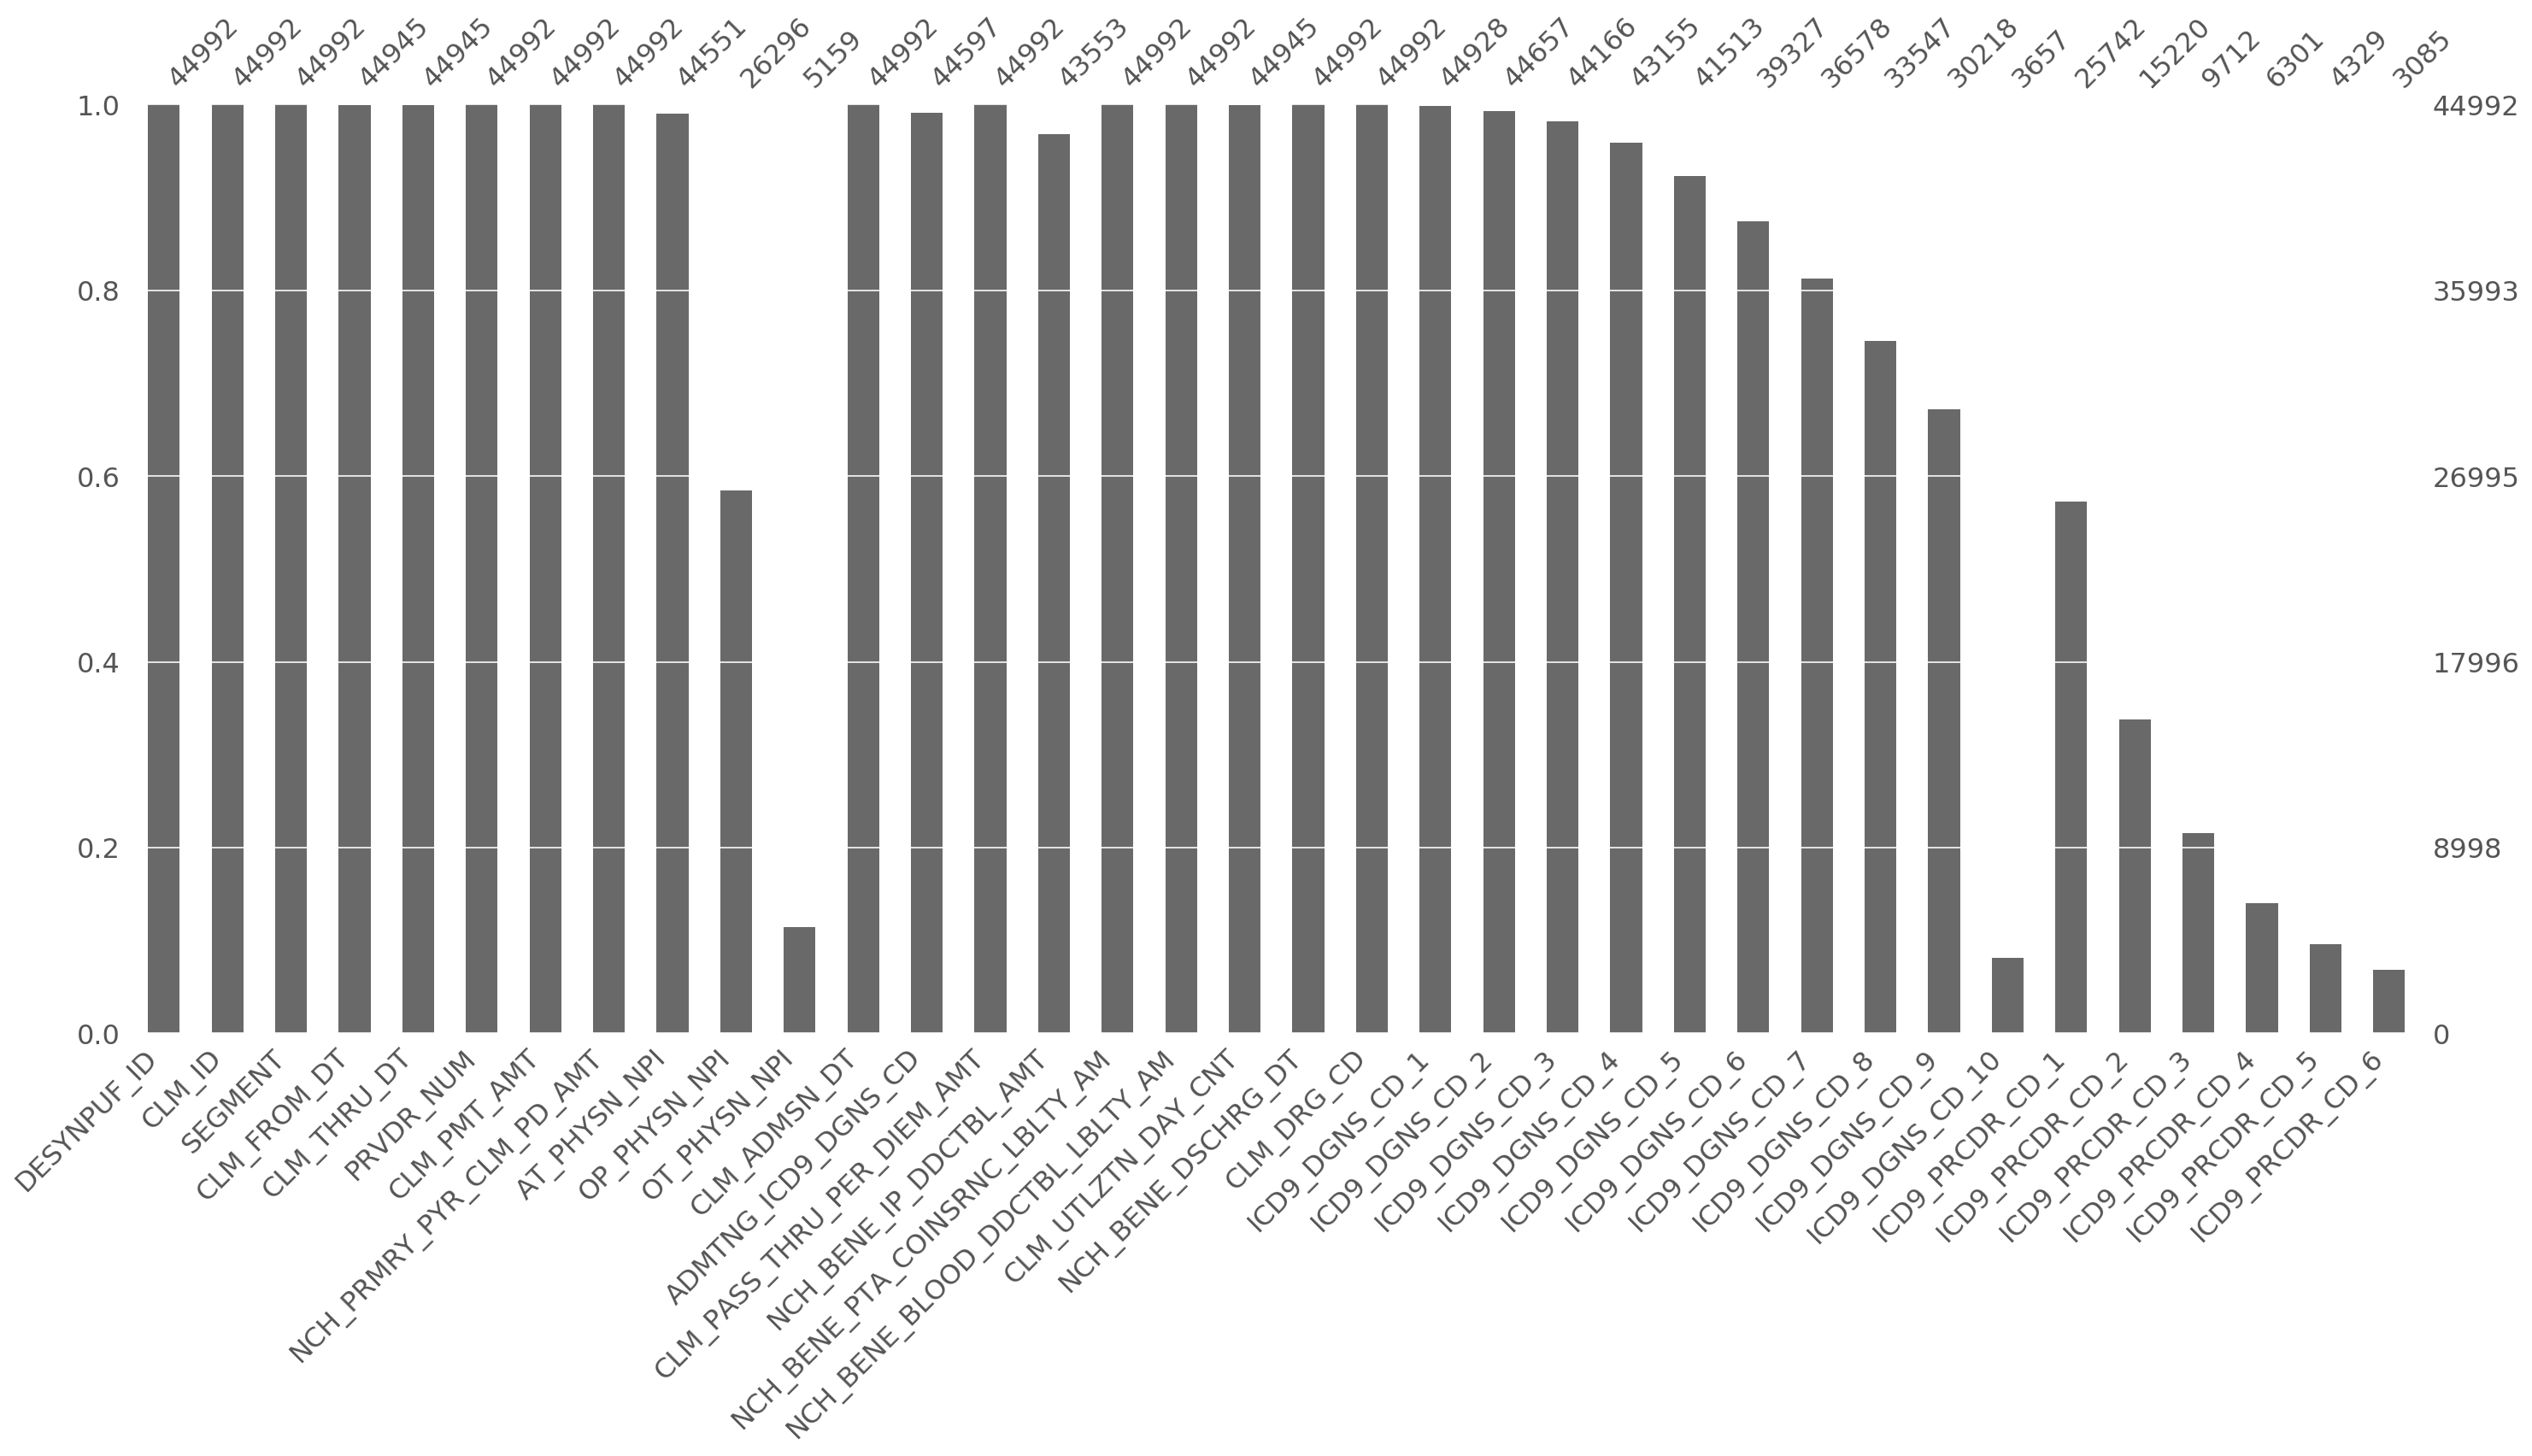

In [10]:
msno.bar(data)
plt.show()

# Memory Optimizations

In [12]:
data.memory_usage()

Index                                 80
DESYNPUF_ID                       359936
CLM_ID                            359936
SEGMENT                           359936
CLM_FROM_DT                       359936
CLM_THRU_DT                       359936
PRVDR_NUM                         359936
CLM_PMT_AMT                       359936
NCH_PRMRY_PYR_CLM_PD_AMT          359936
AT_PHYSN_NPI                      359936
OP_PHYSN_NPI                      359936
OT_PHYSN_NPI                      359936
CLM_ADMSN_DT                      359936
ADMTNG_ICD9_DGNS_CD               359936
CLM_PASS_THRU_PER_DIEM_AMT        359936
NCH_BENE_IP_DDCTBL_AMT            359936
NCH_BENE_PTA_COINSRNC_LBLTY_AM    359936
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    359936
CLM_UTLZTN_DAY_CNT                359936
NCH_BENE_DSCHRG_DT                359936
CLM_DRG_CD                        359936
ICD9_DGNS_CD_1                    359936
ICD9_DGNS_CD_2                    359936
ICD9_DGNS_CD_3                    359936
ICD9_DGNS_CD_4  

In [13]:
data.memory_usage().sum()

12957776

In [14]:
data.dtypes

DESYNPUF_ID                       object
CLM_ID                            object
SEGMENT                           object
CLM_FROM_DT                       object
CLM_THRU_DT                       object
PRVDR_NUM                         object
CLM_PMT_AMT                       object
NCH_PRMRY_PYR_CLM_PD_AMT          object
AT_PHYSN_NPI                      object
OP_PHYSN_NPI                      object
OT_PHYSN_NPI                      object
CLM_ADMSN_DT                      object
ADMTNG_ICD9_DGNS_CD               object
CLM_PASS_THRU_PER_DIEM_AMT        object
NCH_BENE_IP_DDCTBL_AMT            object
NCH_BENE_PTA_COINSRNC_LBLTY_AM    object
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    object
CLM_UTLZTN_DAY_CNT                object
NCH_BENE_DSCHRG_DT                object
CLM_DRG_CD                        object
ICD9_DGNS_CD_1                    object
ICD9_DGNS_CD_2                    object
ICD9_DGNS_CD_3                    object
ICD9_DGNS_CD_4                    object
ICD9_DGNS_CD_5  

In [19]:
for i in data.columns:
    if data[i].dtypes == 'int64':
        data[i] = data[i].astype('uint16')
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('category')

# Plot Analysis

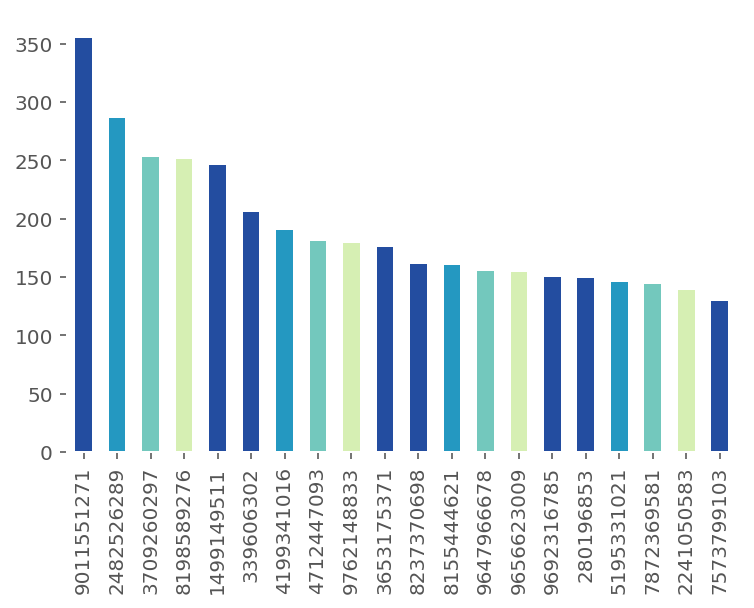

In [20]:
data['AT_PHYSN_NPI'].value_counts().head(20).plot.bar()

In [17]:
data['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].astype(basestring)
data['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].astype(basestring)
data['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].astype(basestring)
data['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].astype(basestring)
data['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].astype(basestring)
data['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].astype(basestring)
data['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].astype(basestring)
data['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].astype(basestring)
data['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].astype(basestring)
data['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].astype(basestring)

data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].astype(basestring)
data['ICD9_PRCDR_CD_2'] = data['ICD9_PRCDR_CD_2'].astype(basestring)
data['ICD9_PRCDR_CD_3'] = data['ICD9_PRCDR_CD_3'].astype(basestring)
data['ICD9_PRCDR_CD_4'] = data['ICD9_PRCDR_CD_4'].astype(basestring)
data['ICD9_PRCDR_CD_5'] = data['ICD9_PRCDR_CD_5'].astype(basestring)
data['ICD9_PRCDR_CD_6'] = data['ICD9_PRCDR_CD_6'].astype(basestring)
#data.dtypes

NameError: name 'basestring' is not defined

In [22]:
'''
data['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].astype(object)
data['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].astype(object)
data['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].astype(object)
data['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].astype(object)
data['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].astype(object)
data['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].astype(object)
data['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].astype(object)
data['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].astype(object)
data['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].astype(object)
data['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].astype(object)

data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].astype(object)
data['ICD9_PRCDR_CD_2'] = data['ICD9_PRCDR_CD_2'].astype(object)
data['ICD9_PRCDR_CD_3'] = data['ICD9_PRCDR_CD_3'].astype(object)
data['ICD9_PRCDR_CD_4'] = data['ICD9_PRCDR_CD_4'].astype(object)
data['ICD9_PRCDR_CD_5'] = data['ICD9_PRCDR_CD_5'].astype(object)
data['ICD9_PRCDR_CD_6'] = data['ICD9_PRCDR_CD_6'].astype(object)
#data.dtypes
'''

"\ndata['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].astype(object)\ndata['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].astype(object)\ndata['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].astype(object)\ndata['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].astype(object)\ndata['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].astype(object)\ndata['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].astype(object)\ndata['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].astype(object)\ndata['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].astype(object)\ndata['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].astype(object)\ndata['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].astype(object)\n\ndata['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].astype(object)\ndata['ICD9_PRCDR_CD_2'] = data['ICD9_PRCDR_CD_2'].astype(object)\ndata['ICD9_PRCDR_CD_3'] = data['ICD9_PRCDR_CD_3'].astype(object)\ndata['ICD9_PRCDR_CD_4'] = data['ICD9_PRCDR_CD_4'].astype(object)\ndata['ICD9_PRCDR_CD_5'] = data['ICD9_PRCDR_CD_5'].astype(object)\ndata['ICD9_PRCDR_CD_6']

In [8]:
data.describe(include='all')
'''
data['ICD9_PRCDR_CD_1'].head(10)
data['ICD9_PRCDR_CD_2'].head(10)
data['ICD9_PRCDR_CD_3'].head(10)
data['ICD9_PRCDR_CD_4'].head(10)
data['ICD9_PRCDR_CD_5'].head(10)
data['ICD9_PRCDR_CD_6'].head(10)
'''
data['ICD9_DGNS_CD_1'].head(10)
data['ICD9_DGNS_CD_2'].head(10)
data['ICD9_DGNS_CD_3'].head(10)
data['ICD9_DGNS_CD_4'].head(10)
data['ICD9_DGNS_CD_5'].head(10)
data['ICD9_DGNS_CD_6'].head(10)
data['ICD9_DGNS_CD_7'].head(10)
data['ICD9_DGNS_CD_8'].head(10)
data['ICD9_DGNS_CD_9'].head(10)
data['ICD9_DGNS_CD_10'].head(10)

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,ADMTNG_ICD9_DGNS_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6
count,44992,44992,44992,44945,44945,44992,44992,44992,44551,26296,5159,44992,44597,44992,43553,44992,44992,44945,44992,44992,44928,44657,44166,43155,41513,39327,36578,33547,30218,3657,25742,15220,9712,6301,4329,3085
unique,25481,44945,2,1120,1096,2572,90,70,13146,9314,3212,1120,2026,15,3,34,18,93,1096,739,2375,2611,2528,2565,2540,2500,2451,2345,2215,921,1139,1695,1412,1131,916,726
top,3A9D94388C426924,196811176977107,1,20080504,20080602,23006G,4000,0,9011551271,9612910514,8523328573,20080504,78605,0,1024,0,0,3,20080602,177,486,4019,4019,4019,4019,4019,4019,4019,4019,4019,9904,4019,4019,4019,4019,4019
freq,12,2,44945,78,83,502,5103,43988,355,222,64,78,1844,32250,17496,44024,44870,7344,83,191,1614,2846,2593,2306,2116,1796,1566,1310,1136,113,1241,989,543,305,205,151


"\ndata['ICD9_PRCDR_CD_1'].head(10)\ndata['ICD9_PRCDR_CD_2'].head(10)\ndata['ICD9_PRCDR_CD_3'].head(10)\ndata['ICD9_PRCDR_CD_4'].head(10)\ndata['ICD9_PRCDR_CD_5'].head(10)\ndata['ICD9_PRCDR_CD_6'].head(10)\n"

0     7802
1     1970
2     6186
3    29623
4     3569
5      486
6    33811
7    49121
8    V5789
9     7366
Name: ICD9_DGNS_CD_1, dtype: object

0    78820
1     4019
2     2948
3    30390
4     4019
5     3004
6    53550
7    25002
8     4279
9    V4365
Name: ICD9_DGNS_CD_2, dtype: object

0    V4501
1     5853
2    56400
3    71690
4     3542
5    42731
6    42820
7     2662
8     2449
9     4104
Name: ICD9_DGNS_CD_3, dtype: object

0     4280
1     7843
2      NaN
3    34590
4    V8801
5    42830
6      496
7     4111
8     2761
9     V145
Name: ICD9_DGNS_CD_4, dtype: object

0     2720
1     2768
2      NaN
3    V1581
4    78820
5     2724
6    V1259
7     4280
8    25000
9     2724
Name: ICD9_DGNS_CD_5, dtype: object

0     4019
1    71590
2      NaN
3    32723
4     2639
5    V4581
6    42731
7     4659
8     5845
9     2720
Name: ICD9_DGNS_CD_6, dtype: object

0    V4502
1     2724
2      NaN
3      NaN
4     7840
5     4019
6    78729
7      NaN
8     4019
9    53081
Name: ICD9_DGNS_CD_7, dtype: object

0    73300
1    19889
2      NaN
3      NaN
4     7856
5      NaN
6     V103
7      NaN
8     4189
9    V5866
Name: ICD9_DGNS_CD_8, dtype: object

0    E9330
1     5849
2      NaN
3      NaN
4     4271
5      NaN
6    34290
7      NaN
8    78729
9     4254
Name: ICD9_DGNS_CD_9, dtype: object

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    496
Name: ICD9_DGNS_CD_10, dtype: object

1. read in lookup table
2. get unique values
3. for each entry in unique list, create empty column
4. for each row in Df, step through prcdr columns and update ohe column to 1 if present (do no increment)

In [24]:
data.shape

(44992, 36)

In [5]:
data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].fillna('0')

In [ ]:
data.dtypes

data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].fillna('0')
data["ICD9_PRCDR_CD_2"] = data["ICD9_PRCDR_CD_2"].fillna('0')
data["ICD9_PRCDR_CD_3"] = data["ICD9_PRCDR_CD_3"].fillna('0')
data["ICD9_PRCDR_CD_4"] = data["ICD9_PRCDR_CD_4"].fillna('0')
data["ICD9_PRCDR_CD_5"] = data["ICD9_PRCDR_CD_5"].fillna('0')
data["ICD9_PRCDR_CD_6"] = data["ICD9_PRCDR_CD_6"].fillna('0')

data['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].fillna('0')
data['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].fillna('0')
data['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].fillna('0')
data['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].fillna('0')
data['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].fillna('0')
data['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].fillna('0')
data['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].fillna('0')
data['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].fillna('0')
data['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].fillna('0')
data['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].fillna('0')

data.shape
#Get proc lookup map 
proc_map = pd.read_csv('ICD9_PRCDR_CD_Mappings.csv',skipinitialspace=True).astype(str)
#proc_map = pd.read_csv('ICD9_PRCDR_CD_Mappings.csv').astype(str)
#proc_map['ICD9_PRCDR_CD_1'] = proc_map['ICD9_PRCDR_CD_1'].astype(str)
#proc_map['Lookup'] = proc_map['Lookup'].astype(str)
#proc_map.columns = proc_map.columns.str.replace(' ', '')
proc_unique = proc_map.Lookup.unique().astype(str)
for index, row in data.iterrows():
  for j in range(len(proc_unique)):
    data['proc_'+str(proc_unique[j])]=0

#data.columns = data.columns.str.replace(' ','')

cmap = proc_map.set_index('ICD9_PRCDR_CD_1')['Lookup']

data['Proc1Lookup'] = data['ICD9_PRCDR_CD_1'].map(cmap, na_action='ignore')
data['Proc2Lookup'] = data['ICD9_PRCDR_CD_2'].map(cmap, na_action='ignore')
data['Proc3Lookup'] = data['ICD9_PRCDR_CD_3'].map(cmap, na_action='ignore')
data['Proc4Lookup'] = data['ICD9_PRCDR_CD_4'].map(cmap, na_action='ignore')
data['Proc5Lookup'] = data['ICD9_PRCDR_CD_5'].map(cmap, na_action='ignore')
data['Proc6Lookup'] = data['ICD9_PRCDR_CD_6'].map(cmap, na_action='ignore')

#data = pd.merge(data, proc_map, how='left', left_on='ICD9_PRCDR_CD_1', right_on='ICD9_PRCDR_CD_1')

#...This works data = pd.merge(data, proc_map, on='ICD9_PRCDR_CD_1')

      
#Get dx lookup map
dx_map = pd.read_csv('ICD9_DX_CD_Mappings.csv',skipinitialspace=True).astype(str)
dx_unique = dx_map.Lookup.unique().astype(str)
for index, row in data.iterrows():
  for j in range(len(dx_unique)):
    data['dx_'+str(dx_unique[j])]=0
    
dmap = dx_map.set_index('ICD9_DGNS_CD_1')['Lookup']

data['Dx1Lookup'] = data['ICD9_DGNS_CD_1'].map(dmap, na_action='ignore')
data['Dx2Lookup'] = data['ICD9_DGNS_CD_2'].map(dmap, na_action='ignore')
data['Dx3Lookup'] = data['ICD9_DGNS_CD_3'].map(dmap, na_action='ignore')
data['Dx4Lookup'] = data['ICD9_DGNS_CD_4'].map(dmap, na_action='ignore')
data['Dx5Lookup'] = data['ICD9_DGNS_CD_5'].map(dmap, na_action='ignore')
data['Dx6Lookup'] = data['ICD9_DGNS_CD_6'].map(dmap, na_action='ignore')
data['Dx7Lookup'] = data['ICD9_DGNS_CD_7'].map(dmap, na_action='ignore')
data['Dx8Lookup'] = data['ICD9_DGNS_CD_8'].map(dmap, na_action='ignore')
data['Dx9Lookup'] = data['ICD9_DGNS_CD_9'].map(dmap, na_action='ignore')
data['Dx10Lookup'] = data['ICD9_DGNS_CD_10'].map(dmap, na_action='ignore')
        
data.dtypes
data.head(10)
proc_map.dtypes
proc_map.head(5)

data['Dx1Lookup'].head(10)
data['Dx2Lookup'].head(10)
data['Dx3Lookup'].head(10)
data['ICD9_DGNS_CD_1'].head(10)
data['ICD9_DGNS_CD_2'].head(10)
data['ICD9_DGNS_CD_3'].head(10)
first5pairs = {k: dmap[k] for k in dmap.keys()[:5]}
first5pairs

data.shape
'''
#debugging prints
proc_map.dtypes
proc_map.head(5)

data['Proc1Lookup'].head(10)
data['Proc2Lookup'].head(10)
data['Proc3Lookup'].head(10)
data['ICD9_PRCDR_CD_1'].head(10)
data['ICD9_PRCDR_CD_2'].head(10)
data['ICD9_PRCDR_CD_3'].head(10)

first5pairs = {k: cmap[k] for k in cmap.keys()[:5]}
first5pairs
'''

DESYNPUF_ID                       object
CLM_ID                            object
SEGMENT                           object
CLM_FROM_DT                       object
CLM_THRU_DT                       object
PRVDR_NUM                         object
CLM_PMT_AMT                       object
NCH_PRMRY_PYR_CLM_PD_AMT          object
AT_PHYSN_NPI                      object
OP_PHYSN_NPI                      object
OT_PHYSN_NPI                      object
CLM_ADMSN_DT                      object
ADMTNG_ICD9_DGNS_CD               object
CLM_PASS_THRU_PER_DIEM_AMT        object
NCH_BENE_IP_DDCTBL_AMT            object
NCH_BENE_PTA_COINSRNC_LBLTY_AM    object
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    object
CLM_UTLZTN_DAY_CNT                object
NCH_BENE_DSCHRG_DT                object
CLM_DRG_CD                        object
ICD9_DGNS_CD_1                    object
ICD9_DGNS_CD_2                    object
ICD9_DGNS_CD_3                    object
ICD9_DGNS_CD_4                    object
ICD9_DGNS_CD_5  

(44992, 36)

In [6]:
#Find null values in KPI columns
#print(data["ICD9_PRCDR_CD_1"].isnull().sum())
print(data["CLM_PMT_AMT"].isnull().sum())
print(data["NCH_PRMRY_PYR_CLM_PD_AMT"].isnull().sum())
print(data["CLM_PASS_THRU_PER_DIEM_AMT"].isnull().sum())
print(data["NCH_BENE_IP_DDCTBL_AMT"].isnull().sum())
print(data["NCH_BENE_PTA_COINSRNC_LBLTY_AM"].isnull().sum())
print(data["NCH_BENE_BLOOD_DDCTBL_LBLTY_AM"].isnull().sum())
print(data["CLM_UTLZTN_DAY_CNT"].isnull().sum())
print(data["CLM_FROM_DT"].isnull().sum())
data.shape

0
0
0
1439
0
0
47
47


(44992, 36)

In [8]:
# Proper change
data["CLM_PMT_AMT"].fillna(data.median, inplace=True)

In [9]:
data["CLM_PMT_AMT"].isnull().sum()

0

In [27]:
data.dropna(subset = ['CLM_FROM_DT'], inplace=True)
#Set null values to median
median = data["CLM_PMT_AMT"].median()
data["CLM_PMT_AMT"].fillna(median, inplace=True)
median = data["NCH_PRMRY_PYR_CLM_PD_AMT"].median()
data["NCH_PRMRY_PYR_CLM_PD_AMT"].fillna(median, inplace=True)
median = data["CLM_PASS_THRU_PER_DIEM_AMT"].median()
data["CLM_PASS_THRU_PER_DIEM_AMT"].fillna(median, inplace=True)
median = data["NCH_BENE_IP_DDCTBL_AMT"].median()
data["NCH_BENE_IP_DDCTBL_AMT"].fillna(median, inplace=True)
median = data["NCH_BENE_PTA_COINSRNC_LBLTY_AM"].median()
data["NCH_BENE_PTA_COINSRNC_LBLTY_AM"].fillna(median, inplace=True)
median = data["NCH_BENE_BLOOD_DDCTBL_LBLTY_AM"].median()
data["NCH_BENE_BLOOD_DDCTBL_LBLTY_AM"].fillna(median, inplace=True)
median = data["CLM_UTLZTN_DAY_CNT"].median()
data["CLM_UTLZTN_DAY_CNT"].fillna(median, inplace=True)

TypeError: Categorical cannot perform the operation median

In [28]:
data['CLM_PMT_AMT'] = data['CLM_PMT_AMT'].astype(float)
data['NCH_PRMRY_PYR_CLM_PD_AMT'] = data['NCH_PRMRY_PYR_CLM_PD_AMT'].astype(float)
data['CLM_PASS_THRU_PER_DIEM_AMT'] = data['CLM_PASS_THRU_PER_DIEM_AMT'].astype(float)
data['NCH_BENE_IP_DDCTBL_AMT'] = data['NCH_BENE_IP_DDCTBL_AMT'].astype(float)
data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'] = data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].astype(float)
data['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'] = data['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'].astype(float)
#compute Log of KPIs
data["LOG_CLM_PMT_AMT"] = np.log(1+data.CLM_PMT_AMT)
data["LOG_NCH_PRMRY_PYR_CLM_PD_AMT"]  = np.log(1+data.NCH_PRMRY_PYR_CLM_PD_AMT)
data["LOG_CLM_PASS_THRU_PER_DIEM_AMT"]  = np.log(1+data.CLM_PASS_THRU_PER_DIEM_AMT)
data["LOG_NCH_BENE_IP_DDCTBL_AMT"]  = np.log(1+data.NCH_BENE_IP_DDCTBL_AMT)
data["LOG_NCH_BENE_PTA_COINSRNC_LBLTY_AM"] = np.log(1+data.NCH_BENE_PTA_COINSRNC_LBLTY_AM)
data["LOG_NCH_BENE_BLOOD_DDCTBL_LBLTY_AM"] = np.log(1+data.NCH_BENE_BLOOD_DDCTBL_LBLTY_AM)


'''Example of gross ration
data["LOG_COLLECTED_RATIO"] = data["LOG_COLLECTED"]/data["LOG_AMOUNT"]
ratio_median = data["LOG_COLLECTED_RATIO"].median()
data["LOG_COLLECTED_RATIO"].fillna(ratio_median, inplace=True)
'''

data.shape

'Example of gross ration\ndata["LOG_COLLECTED_RATIO"] = data["LOG_COLLECTED"]/data["LOG_AMOUNT"]\nratio_median = data["LOG_COLLECTED_RATIO"].median()\ndata["LOG_COLLECTED_RATIO"].fillna(ratio_median, inplace=True)\n'

(44945, 42)

In [29]:
data[['proc_311','proc_8659','proc_OTHER_PROC']].dtypes
for index, row in data.iterrows():
    code = str(row['Proc1Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ code] = 1 
#    else:
#        data.loc[index, 'proc_OTHER_P'+ code] = 0.0
#    data['proc_'+ str(code)].fillna(value=0.0,inplace=True)


    code = str(row['Proc2Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ str(code)] = 1    
#    else:
#        data.loc[index, 'proc_'+ str(code)] = 0.0
#    data['proc_'+ str(code)].fillna(value=0.0,inplace=True)

    code = str(row['Proc3Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ str(code)] = 1    
        
    code = str(row['Proc4Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ str(code)] = 1    
        
    code = str(row['Proc5Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ str(code)] = 1    
        
    code = str(row['Proc6Lookup'])
    if code <> 'nan':
        data.loc[index, 'proc_'+ str(code)] = 1  

SyntaxError: invalid syntax (<ipython-input-29-cccf87797458>, line 4)

In [ ]:
'''
#Check Proc assignments
data.shape
data[['proc_311','proc_8659','proc_OTHER_PROC']].dtypes
data['proc_8659'].head(10)
data['proc_311'].head(10)
data['proc_OTHER_PROC'].head(10)
'''

In [ ]:
for index, row in data.iterrows():
    code = str(row['Dx1Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1 
#    else:
#        data.loc[index, 'dx_'+ str(code)] = 0.0
#    data['dx_'+ str(code)].fillna(value=0.0,inplace=True)

    code = str(row['Dx2Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1    

    code = str(row['Dx3Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1    
        
    code = str(row['Dx4Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1    
        
    code = str(row['Dx5Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1    
        
    code = str(row['Dx6Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1  

    code = str(row['Dx7Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1  

    code = str(row['Dx8Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1  

    code = str(row['Dx9Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1  

    code = str(row['Dx10Lookup'])
    if code <> 'nan':
        data.loc[index, 'dx_'+ str(code)] = 1      

In [ ]:
#Check Dx assignments
data.shape
data[['dx_7802','dx_4019','dx_OTHER_DX']].dtypes
data['dx_7802'].head(10)
data['dx_4019'].head(10)
data['dx_OTHER_DX'].head(10)

In [ ]:
data = data.drop(['Proc1Lookup','Proc2Lookup','Proc3Lookup','Proc4Lookup','Proc5Lookup','Proc6Lookup'], axis=1)
data = data.drop(['Dx1Lookup','Dx2Lookup','Dx3Lookup','Dx4Lookup','Dx5Lookup','Dx6Lookup','Dx7Lookup','Dx8Lookup','Dx9Lookup','Dx10Lookup'], axis=1)
data.shape

In [ ]:
#Create year, month, week, day of week columns for dates
#df['time'] = df['time'].astype('datetime64[ns]')

data['CLM_FROM_DT'].head(5)
data['CLM_FROM_DT'] = pd.to_datetime(data['CLM_FROM_DT'].astype(str),format='%Y%m%d')
data['CLM_THRU_DT'] = pd.to_datetime(data['CLM_THRU_DT'].astype(str),format='%Y%m%d')
data['CLM_ADMSN_DT'] = pd.to_datetime(data['CLM_ADMSN_DT'].astype(str),format='%Y%m%d')
data['CLM_FROM_DT'].head(5)



In [ ]:
print(data['CLM_FROM_DT'].isnull().sum())
data['CLM_FROM_Year'] = data['CLM_FROM_DT'].dt.year
data['CLM_FROM_Month'] = data['CLM_FROM_DT'].dt.month
data['CLM_FROM_Day'] = data['CLM_FROM_DT'].dt.day
data['CLM_FROM_DOW'] = data['CLM_FROM_DT'].dt.dayofweek

data.dropna(subset = ['CLM_FROM_DT','CLM_FROM_Year','CLM_FROM_Month','CLM_FROM_Day','CLM_FROM_DOW'])

data['CLM_FROM_DT'].head(5)
data['CLM_FROM_Year'].head(5)
data['CLM_FROM_Month'].head(5)
data['CLM_FROM_Day'].head(5)
data['CLM_FROM_DOW'].head(5)

print(data['CLM_FROM_Year'].isna().sum())
print(data['CLM_FROM_Month'].isnull().sum())
print(data['CLM_FROM_Day'].isnull().sum())
print(data['CLM_FROM_DOW'].isnull().sum())
print(data['CLM_FROM_DT'].isnull().sum())

In [ ]:
#Read in demo info
demo_info = pd.read_csv('DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv')
data.shape
demo_info.shape
#Compute derived demo variables
demo_info['BENE_BIRTH_DT'] = pd.to_datetime(demo_info['BENE_BIRTH_DT'].astype(str),format='%Y%m%d')
demo_info.head(10)




In [ ]:
data.head(10)
demo_info.head(10)
merged_data = pd.merge(data, demo_info, on='DESYNPUF_ID')
merged_data.shape
merged_data.head(10)


In [ ]:
#compute derived features
#1. Age group
#merged_data['BENE_BIRTH_DT'] = pd.to_datetime(merged_data['BENE_BIRTH_DT'].astype(str),format='%Y%m%d')
merged_data['BENE_Age_Group'] = ((merged_data['CLM_FROM_DT'] - merged_data['BENE_BIRTH_DT']).dt.days / (20*365)).round(0)
merged_data['BENE_BIRTH_DT'].head(10)
merged_data['CLM_FROM_DT'].head(10)
merged_data['BENE_Age_Group'].head(10)

In [ ]:
merged_data.dtypes
merged_data.to_csv('Demo_CMS_IP_features_columns.csv',index=False, header=True)